Используя набор данных IMDB была спроектирована модель классификации отзывов к фильмам.
Показано, что модель способна классифицировать отзывы с вероятностью более 88% на контрольной выборке

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5446 - loss: 0.6918
Epoch 1: val_accuracy improved from -inf to 0.73720, saving model to best_w.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5455 - loss: 0.6917 - val_accuracy: 0.7372 - val_loss: 0.6846 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6348 - loss: 0.6822
Epoch 2: val_accuracy did not improve from 0.73720
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6344 - loss: 0.6822 - val_accuracy: 0.6656 - val_loss: 0.6714 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6754 - loss: 0.6646
Epoch 3: val_accuracy did not improve from 0.73720
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6757 - loss: 0.6645 - val_accuracy: 0.6584 - val_loss: 0.6526 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7070 - loss: 0.6410
Epoch 4: val_accuracy improved from 0.73720 to 0.74080, saving mod

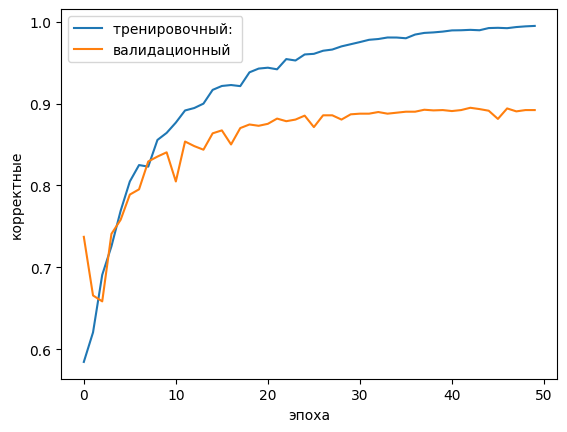

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8995 - loss: 0.2540
финальная точнасть: 0.9002


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D # я уже не знаю, GlobalAveragePooling1D лучше себя показал, разве что LSTM еще можно попробовать
#from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences #судя по уроку нули модели не особо мешают
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline



for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

max_words = 25000
maxlen = 400 #меньше не особо помогает

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)


def create_ngram_set(input_list, ngram_value=2):
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

# Размерность
ngram_range = 2
ngram_set = set()
for input_list in x_train:
    for i in range(2, ngram_range + 1):
        set_of_ngram = create_ngram_set(input_list, ngram_value=i)
        ngram_set.update(set_of_ngram)

start_index = max_words + 1
token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
indice_token = {token_indice[k]: k for k in token_indice}

max_features = np.max(list(indice_token.keys())) + 1

def add_ngram(sequences, token_indice, ngram_range=2):
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

x_train = add_ngram(x_train, token_indice, ngram_range)
x_test = add_ngram(x_test, token_indice, ngram_range)

x_train = pad_sequences(x_train, maxlen=maxlen * 2)
x_test = pad_sequences(x_test, maxlen=maxlen * 2)

model = Sequential()
model.add(Embedding(max_features, 50))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=5,
                              min_lr=0.00001, # все равно слишком быстро
                              verbose=1)

save_best = ModelCheckpoint(filepath="best_w.keras",
                            monitor="val_accuracy",
                            save_best_only=True,
                            mode="auto",
                            verbose=1)

history = model.fit(x_train,
                    y_train,
                    epochs=50, # после ранней остановки убрать
                    batch_size=512,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[reduce_lr, save_best])

plt.plot(history.history['accuracy'],
         label='тренировочный: ')
plt.plot(history.history['val_accuracy'],
         label='валидационный')
plt.xlabel('эпоха')
plt.ylabel('корректные')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'финальная точнасть: {test_accuracy:.4f}')
